In [40]:
import numpy as np
import scipy.integrate as integral
from scipy import integrate
import matplotlib.pyplot as plt

<h1>Growth Terms</h1>

In the next codes, we will calculate $\Upsilon^{\alpha}$, $\Delta \sigma$, and $\Delta \tau$ with

\begin{equation}
\Upsilon^{\alpha}(\tau) = 1 + K^{\alpha}_{\sigma} \Delta \sigma (\tau) - K^{\alpha}_{\tau} \Delta \tau_w (\tau)\qquad \text{and}\qquad \Delta \sigma = \frac{\tilde{\sigma}(t)}{\tilde{\sigma}_0} - 1
\end{equation}



Function `growth_terms(internal_effect, K_Upsilon)` will get a dictionary which has information about normal stress and shear stress and the coefficients used for Upsilon. This function will return $[\Delta \sigma, \Delta \tau, \Upsilon]$


In [41]:
def growth_terms(internal_effect, K_Upsilon):
    
    # internal_effect = {"stress" : [sigma_h, sigma_curr], "tau" : [tau_h, tau_curr]}
    # Internal effect is a dictionary composed of stress and shear sress (here we call it tau)
    ###### sigma_curr is the current stress and sigma_h is the homeostasis stress
    ###### tau_curr is the current shear stress and tau_h is the homeostasis shear stress.
    # K_Upsilon is an array with all the constants in Upsilon function
    # K_Upsilon = [K_sigma, K_tau]
    
    
    sigma_h     = internal_effect["stress"][0]
    sigma_curr  = internal_effect["stress"][-1]
    D_sigma     = ( sigma_curr - sigma_h ) / sigma_h
    
    
    tau_h       = internal_effect["tau"][0]
    tau_curr    = internal_effect["tau"][-1]
    D_tau       = ( tau_curr - tau_h ) / tau_h
    
    
    K_sigma     = K_Upsilon[0]
    K_tau       = K_Upsilon[1]
    
    Upsil       = 1 + K_sigma * D_sigma - K_tau * D_tau
    
    return [D_sigma, D_tau, Upsil]


<h1>Density</h1>

The volution of the referential mass density is proposed as



\begin{equation}
\rho^{\alpha}_{R}(s) = \int_{-\infty}^s m^{\alpha}_R(\tau) q^{\alpha}(s,\tau)d\tau,\qquad q^{\alpha}(s,\tau) =\exp(-\int_{\tau}^s k^{\alpha}(t) dt),\qquad k^{\alpha}(t) = k_0^{\alpha} (1 + (\Delta \sigma)^2) \qquad \text{and}\qquad m^{\alpha}_R(\tau) = m^{\alpha}_N(\tau) \Upsilon^{\alpha}
\end{equation}

In [42]:
def q(internal_effect, k_q, past_time, current_time):
    
    # current_time in the integral for q is shown by s
    # past_time in the integral for q is shown by tau
    
    D_sigma = growth_terms(internal_effect, K_Upsilon)[0]
    D_tau   = growth_terms(internal_effect, K_Upsilon)[1]
    
    return np.exp(integral.quad(lambda x: -1*k_q*(D_sigma**2 + 1), past_time, current_time)[0])


    # if we assume that k_q is not a function of time, then 
#     return np.exp(k_q*(D_sigma**2 + 1) * (past_time - current_time))

    




def referential_density(internal_effect, K_Upsilon, 
                       k_q, current_time, past_time, time_step):
    
    
    # growth_term is m_R(tau) = m_N (tau) Upsilon
    growth_term = m_N * growth_terms(internal_effect, K_Upsilon)[2]
    
    
    time_interval = np.linspace(past_time, current_time, num = time_step)
    
    
    density = np.array([integral.quad(lambda x: growth_term * q(internal_effect, k_q, x, current_time),
                            past_time, x
                            )[0] for x in time_interval])
    
    return density[-1]
    
    

<h3>Example</h3>

In the following example, let
\begin{equation}
\Delta \sigma = \Delta \tau =0 \longrightarrow\Upsilon^{\alpha} = 1 \qquad k^{\alpha}(t) = 1\qquad s = 2 \qquad m^{\alpha}_R(\tau) = 1 \quad m_0 = 1 \quad \text{for}\quad \tau\ge 0
\end{equation}

then we have

\begin{equation}
q^{\alpha}(s,\tau) =e^{(\tau - s)}
\end{equation}

then we will have
\begin{equation}
\rho^{\alpha}_{R}(s) = \int_{-\infty}^s m^{\alpha}_R(\tau) e^{(\tau - s)}d\tau
\end{equation}

and

\begin{equation}
\text{if}\quad m^{\alpha}_R(\tau) = m_0\quad \text{then}\quad \rho^{\alpha}_{R}(s) = m_0\int_{-\infty}^2 e^{(\tau - 2)}d\tau = \frac{1}{e^2} (e^2 ) = 1
\end{equation}


In the next example, we show how to update stress $\sigma$ and shear stress $\tau$ in the code in the dictionary called `internal_effect`.

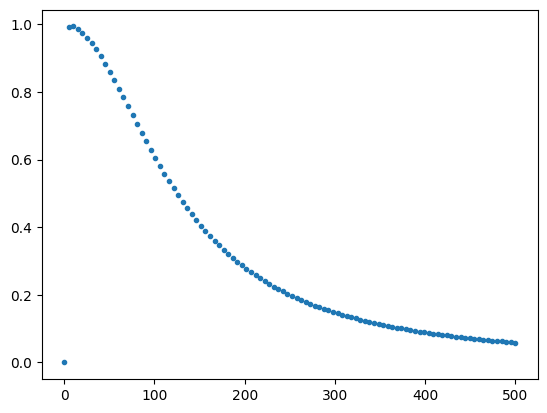

In [43]:
# internal_effect = {"stress" : [sigma_h, sigma_curr], "tau" : [tau_h, tau_curr]}
internal_effect = {"stress" : [1], "tau" : [1]}

# K_Upsilon = [K_sigma, K_tau]
K_Upsilon = [1, 1]

k_q = 1
m_N = 1
current_time = 500
past_time = 0
time_step = 100

density_time =[]

time_range   = np.linspace(past_time, current_time, num=time_step)
stress_range = np.linspace(1, 5, num=time_step)
tau_range    = np.linspace(1, 5, num=time_step)

for time, stress, tau in zip(time_range, stress_range, tau_range):
    
    internal_effect["stress"].append(stress)
    internal_effect["tau"].append(tau)

    d = referential_density(internal_effect, K_Upsilon, 
                       k_q, time, past_time, time_step)
    density_time.append(d)



plt.plot(time_range, density_time, ".")
plt.show()


<h1>Calculating the stress</h1>

There are two types of stress tensors that we need to calculate.

First one is the stress that different constitutents feel and it is calculated by using changes in the pressure ($P$) and flow ($Q$) in the artery. By using changes in the pressure and the flow, we find changes in the geometry of the artery as it wants to go back to its homestasis state. Also we use this stress to find deviation from homeostasis stress in the equation for densities.

Second one is the the stress in the TEVG.  To calculate this stress we use principal stretches due to changes in the geometry of the artery. 

Assume that we model the structures as Neo-Hookean materials, then if we show the first Piola Kirchhoff by $\textbf{P}$ and Cauchy stress tensor by $\textbf{T}$, we have

\begin{equation}
W=\frac{c}{2}(\textbf{F} \cdot \textbf{F} - 3) \longrightarrow \textbf{P} = c \textbf{F} - q J \textbf{F}^{-T} \qquad\text{and}\qquad \textbf{T} = J^{-1} \textbf{P} \textbf{F}^{T} \longrightarrow \textbf{T} = J^{-1} c \textbf{B} -q \textbf{I}
\end{equation}
where q is Lagrange multiplier to enforce incompressibility which must be calculated by using balance law and the boundary conditions. Also
\begin{equation}
\textbf{B} = \sum_i^3 \lambda_i^2 \textbf{u}_i\otimes \textbf{u}_i\qquad \text{where } \lambda_i \text{ are principle stretches}
\end{equation}
also due to incompressibility, we have
\begin{equation}
\lambda_z = \frac{1}{\lambda_r \lambda_{\theta}}\qquad \text{and}\qquad J = 1
\end{equation}

To calculate the principle stretches, first, we use the following equations to find homeostasis normal and shear stresses

\begin{equation}
\sigma = \frac{Pr}{t}\qquad \qquad \tau = \frac{4\mu Q}{\pi r^3}
\end{equation}

and if we chage the pressure and flow as
\begin{equation}
P_1 \to \gamma P_0 \qquad \text{and}\qquad Q_1 \to \epsilon Q_0
\end{equation}

then the thickness and the radius change as

\begin{equation}
t_1 \to \gamma (\varepsilon^{\frac{1}{3}}) t_0\qquad \text{and}\qquad r_1 = (\varepsilon^{\frac{1}{3}}) r_0
\end{equation}

which can be used to calculate the following stretches

\begin{equation}
\lambda_{\tau} = 
\end{equation}



In [44]:
def update_geometry(geom, pressure_flow):
    
    # geom = {"thickness": [t_h], "radius": [r_h]}
    # pressure_flow = {"pressure": [pressure_h, pressure_curr], "flow": [flow_h, flow_curr]}
    
    
    
    if len(pressure_flow["pressure"]) == 1:
        gamma = 1
    else:
        P_h     = pressure_flow["pressure"][0]
        P_curr  = pressure_flow["pressure"][-1]
        gamma   = (P_curr - P_h) / P_h

    
    
    if len(pressure_flow["flow"]) == 1:
        epsilon = 1
    else:
        Q_h     = pressure_flow["flow"][0]
        Q_curr  = pressure_flow["flow"][-1]
        epsilon = (Q_curr - Q_h) / Q_h
    
    geom["thickness"].append(geom["thickness"][0] * gamma * epsilon**(1/3))
    geom["radius"].append(geom["radius"][0] * epsilon**(1/3))
    
    return geom

<h2>Example</h2>

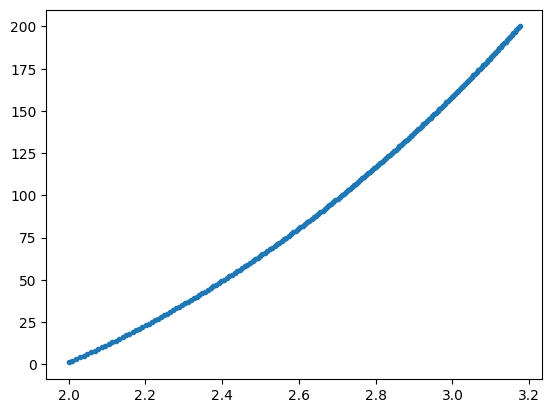

In [45]:
geom = {"thickness": [1], "radius": [2]}
pressure_flow = {"pressure": [1], "flow": [1]}

step = 200

pressure_range = np.linspace(1, 2, num=step)
flow_range     = np.linspace(2, 5, num=step)

radius = [2]
thickness = [1]

for pressure, flow in zip(pressure_range, flow_range):
    
    pressure_flow["pressure"].append(pressure)
    pressure_flow["flow"].append(flow)
    

    radius.append(update_geometry(geom, pressure_flow)["radius"][-1])
    thickness.append(update_geometry(geom, pressure_flow)["thickness"][-1])
    
    

plt.plot(radius[1:], np.linspace(1, step , num= step ), '.')
plt.show()